In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [2]:
from brs.ingestion import LoadLocalDataset

lld = LoadLocalDataset()

data_books = lld.load_dataset("books")
data_users = lld.load_dataset("users")
data_ratings = lld.load_dataset("ratings")

d:\z\Conspects\_Summer\BRS\brs\ingestion\load_local.py:42: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(dataset_path)


## Краткое описание датасетов

1. data_ratings - датасет, представляющий из себя три колонки ID пользователя, ID книги и оценку от пользователя для этой книги
2. data_users - также датасет из трех колонок - ID, адрес, возраст
3. data_books - датасет с книгами: ID(ISBN), title, автор, издательство, год

## Датасет с пользователями data_users

In [3]:
print(data_users.count())
data_users.head()

User-ID     278858
Location    278858
Age         168096
dtype: int64


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Посмотрим для начала на пропуски в данных.

Тут стоит обратить внимание на то, что в Location пропусков нет, но там иногда встречаются странные результаты. Хочется из всех Location вытащить страны, но не везде это возможно. Иногда адреса неполные

In [4]:

from brs.analysis import NAInspection

NAInspection(dataset_name="users").inspect(data_users)



print(f"\nПример странного адреса: '{data_users.iloc[18]["Location"]}'")

users total size 278858
          NaN count   NaN %
User-ID           0    0.0%
Location          0    0.0%
Age          110762  39.72%

Пример странного адреса: 'weston, ,'


Заметим, что у нас есть очевидные выбросы в виде каких-то подозрительно старых и молодых читателе

Number of very young users: 908
Number of very old users: 366


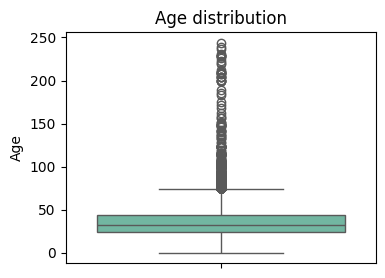

In [5]:
from brs.analysis import BoxPlotInspection

print(f"Number of very young users: {(data_users["Age"] < 6).sum()}")
print(f"Number of very old users: {(data_users["Age"] > 100).sum()}")
BoxPlotInspection("Age", title="Age distribution", figsize=(4,3)).inspect(data_users)

На основании этих наблюдений сделаем простой препроцессинг:
- Укажем типы: str и "Int64" для значениий
- Уберем выбросы для возрастов: все возраста <5 и >90 заменим на None

In [6]:
data_users["Location"] = data_users["Location"].astype(str)
data_users.isna().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [7]:
from brs.preprocessing import UsersPreprocessingStrategy

data_users = UsersPreprocessingStrategy().preprocess(data_users)

Добавим несколько новых фич

- Сгрупируем читателей в возрастные группы ["0-12", "13-17", "18-29", "30-44", "45-59", "60+"]
- Вычленим из адресов страны
- Воспользуемся датасетом с выставленными пользователями оценками и подсчитаем для каждого пользователя количество оценок и среднюю оценку, которую он ставил книгам

In [8]:
data_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [9]:
from brs.feature_engineering import AgeGroupsFeature, CountryFeature, MeanRatingFeature, NumRatingsFeature

data_users = AgeGroupsFeature().apply_transformation(data_users)
data_users = CountryFeature().apply_transformation(data_users)
data_users = MeanRatingFeature(ratings_df=data_ratings).apply_transformation(data_users)
data_users = NumRatingsFeature(ratings_df=data_ratings).apply_transformation(data_users)

С данными по числу рейтингов вообще происходит какой-то ужас. 
1. Есть какие-то пользователи, которые оставили тысячи отзывов
2. Адекватная картина по число отзывов у нас выстраивается только для тех, кто оставил где-то от 2 до 15 отзывов
3. 60% пользователей не оставляли вообще никаких отзывов, что делает их для нас по сути бесполезными

К вопросу "Что делать?" мы вернемся чуть позже при рассмотрении датасета с рейтингами

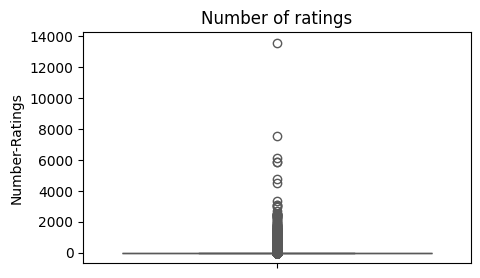

Number of zero reviews users: 173575(62.24%)


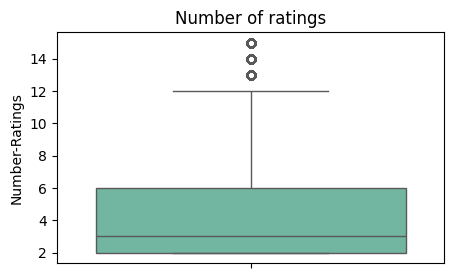

In [10]:
from brs.analysis import BoxPlotInspection

BoxPlotInspection("Number-Ratings", title="Number of ratings", figsize=(5,3)).inspect(data_users)

print(f"Number of zero reviews users: {data_users[data_users['Number-Ratings'] == 0].shape[0]}({data_users[data_users['Number-Ratings'] == 0].shape[0] / data_users.shape[0] * 100:.2f}%)")

tdf = data_users[(data_users["Number-Ratings"] < 16) & (data_users["Number-Ratings"] > 1)].copy()
BoxPlotInspection("Number-Ratings", title="Number of ratings", figsize=(5,3)).inspect(tdf)

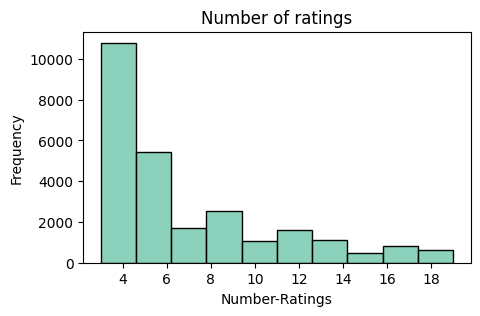

In [11]:
from brs.analysis import HistogramInspection

tdf = data_users[(data_users["Number-Ratings"] < 20) & (data_users["Number-Ratings"] > 2)].copy()
HistogramInspection("Number-Ratings", title="Number of ratings", figsize=(5,3)).inspect(tdf)

В датасете подозрительно много пользователей, которые любят ставить нули, что вызывает сомнения в точности данных по этим пользователям. Вряд ли люди продолжают читать книги, если им вообще ничего не нравится.

Распределение же, если выкинуть нули из расчета, выглядит значительно более адекватно

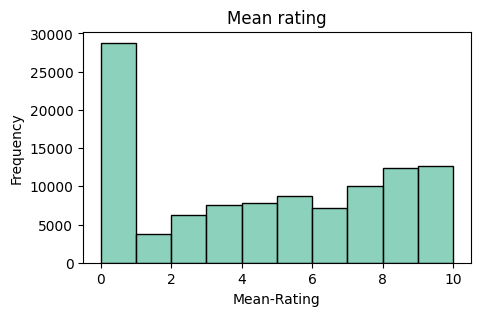

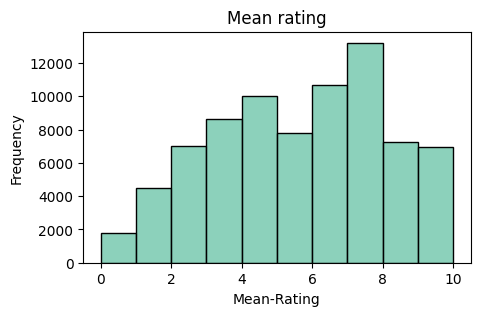

In [12]:
from brs.analysis import HistogramInspection

HistogramInspection("Mean-Rating", title="Mean rating", figsize=(5,3)).inspect(data_users)

tdf = data_users[data_users["Mean-Rating"] != 0].copy()
HistogramInspection("Mean-Rating", title="Mean rating", figsize=(5,3)).inspect(tdf)

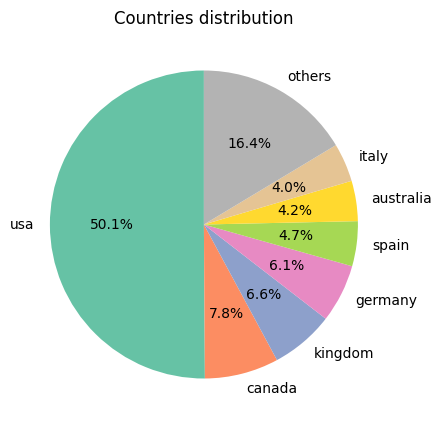

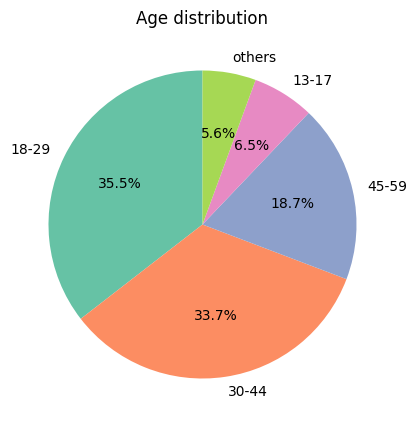

In [13]:
from brs.analysis import PieChartInspection

PieChartInspection("Countries", title="Countries distribution", top_n=7, dropna=False, figsize=(5,5)).inspect(data_users)
PieChartInspection("Age_group", title="Age distribution", top_n=4, dropna=True, figsize=(5,5)).inspect(data_users)

Таким образом

- Около 70% пользователей из англоговорящих стран 
- Почти про всех пользователей мы знаем его страну
- В основном читатели это молодые взрослые
- В данных по возрасту много пропущенных значений

В дальнейшем можно попробовать добавить информацию об отдельных регионах

## Датасет с книгами data_books

In [14]:
data_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### Анализ пропусков

На первый взгляд в датасете почти нет пропусков

In [15]:
from brs.analysis import NAInspection

NAInspection(dataset_name="books").inspect(data_books)

books total size 271360
                     NaN count NaN %
ISBN                         0  0.0%
Book-Title                   0  0.0%
Book-Author                  2  0.0%
Year-Of-Publication          0  0.0%
Publisher                    2  0.0%
Image-URL-S                  0  0.0%
Image-URL-M                  0  0.0%
Image-URL-L                  3  0.0%


In [16]:
data_books[data_books["Book-Author"].isna()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


Однако в Year-Of-Publication можно найти подозрительные записи, которые должны быть заменены на NaN

In [17]:
print((data_books["Year-Of-Publication"] == "0").sum())
data_books[data_books["Year-Of-Publication"]  == "0"].head()

1048


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
196656,3442035368,Ich Gestehe,Heinz G. Konsalik,0,Wilhelm Goldmann Verlag GmbH,http://images.amazon.com/images/P/3442035368.0...,http://images.amazon.com/images/P/3442035368.0...,http://images.amazon.com/images/P/3442035368.0...
196678,0553124803,Being There,Jerzy Kosinski,0,Bantam Doubleday Dell,http://images.amazon.com/images/P/0553124803.0...,http://images.amazon.com/images/P/0553124803.0...,http://images.amazon.com/images/P/0553124803.0...
196680,888274387X,Vaniglia E Cioccolato,Modignani Casati,0,Sperling Paperback,http://images.amazon.com/images/P/888274387X.0...,http://images.amazon.com/images/P/888274387X.0...,http://images.amazon.com/images/P/888274387X.0...
196685,033368155X,Surreal Lives the Surrealists 1945,Ruth Brandon,0,Humanity Press/prometheus Bk,http://images.amazon.com/images/P/033368155X.0...,http://images.amazon.com/images/P/033368155X.0...,http://images.amazon.com/images/P/033368155X.0...
196734,0207158452,Games of the Strong,Glenda Adams,0,Harpercollins Publisher,http://images.amazon.com/images/P/0207158452.0...,http://images.amazon.com/images/P/0207158452.0...,http://images.amazon.com/images/P/0207158452.0...


Также в Year-Of-Publication несколько раз лежат не целочисленные значения.

- Очевидно, колонки съехали на одну влево, а автор является NaN значением
- Однако вряд ли эти записи нам критически важны
- Проще будет откинуть на текущем этапе значения с кривыми Year-Of-Publication

In [18]:
mask = ~data_books["Year-Of-Publication"].astype(str).str.isnumeric()
data_books[mask]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


### Анализ дубликатов

Посмотрим на распределение книг, авторов и издательств в датасете

- Заметим, что в датасете довольно много дубликатов
- Однако оставить на каждое отдельное произведение только одну книгу, скорее всего, плохая идея, так как людям может быть интересна серия от конкретного издательства

Сделаем два вывода:

1. Нужно проверить датасет на наличие полных дубликатов и удалить их, если они есть
2. Есть смысл поэксперементировать с добавлением в данные фичи, которая бы явно связывала одинаковые книги, но разного года издания и от разных издательств

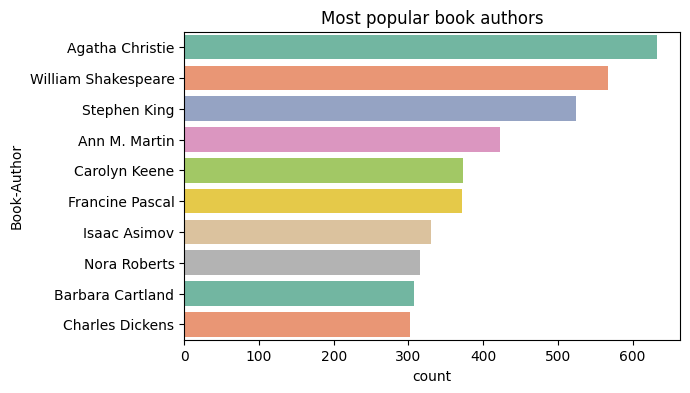

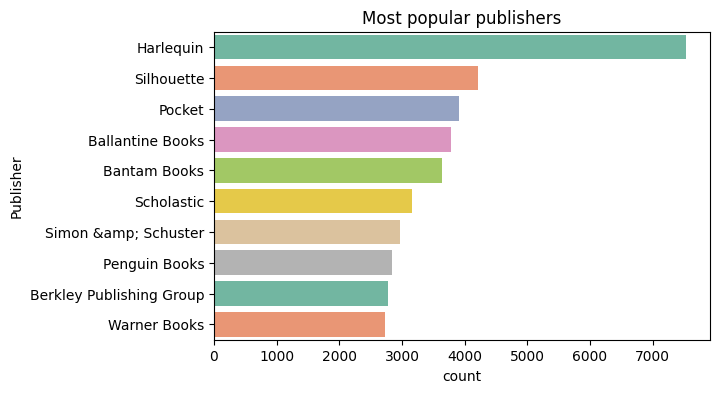

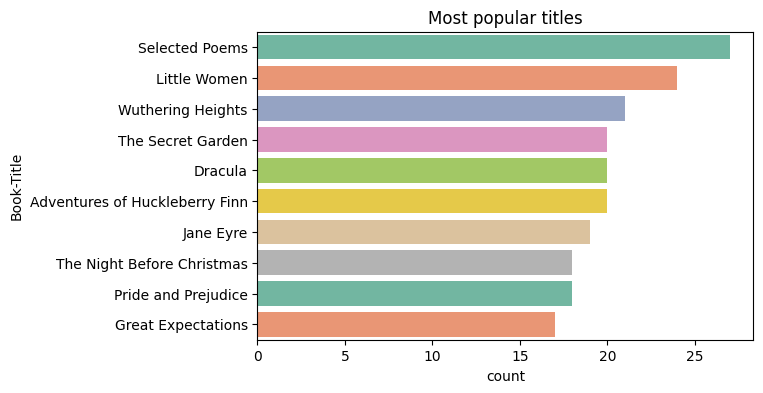

In [19]:
from brs.analysis import BarChartInspection

BarChartInspection("Book-Author", title="Most popular book authors", top_n=10, dropna=False, figsize_scale=0.8).inspect(data_books)
BarChartInspection("Publisher", title="Most popular publishers", top_n=10, dropna=False, figsize_scale=0.8).inspect(data_books)
BarChartInspection("Book-Title", title="Most popular titles", top_n=10, dropna=False, figsize_scale=0.8).inspect(data_books)

Дальше проверяем полные дубликаты

Видно, что полные дубликаты в датасете встречаются, однако у них всех разный ISBN

Это можно объяснить либо ошибкой в данных, либо тем, что для Phonics Fun выпустили 12 редакций за 2003 год. Второе объяснение звучит маловероятно, поэтому, скорее всего, есть смысл избавится в данных от всех дублирующихся книг.

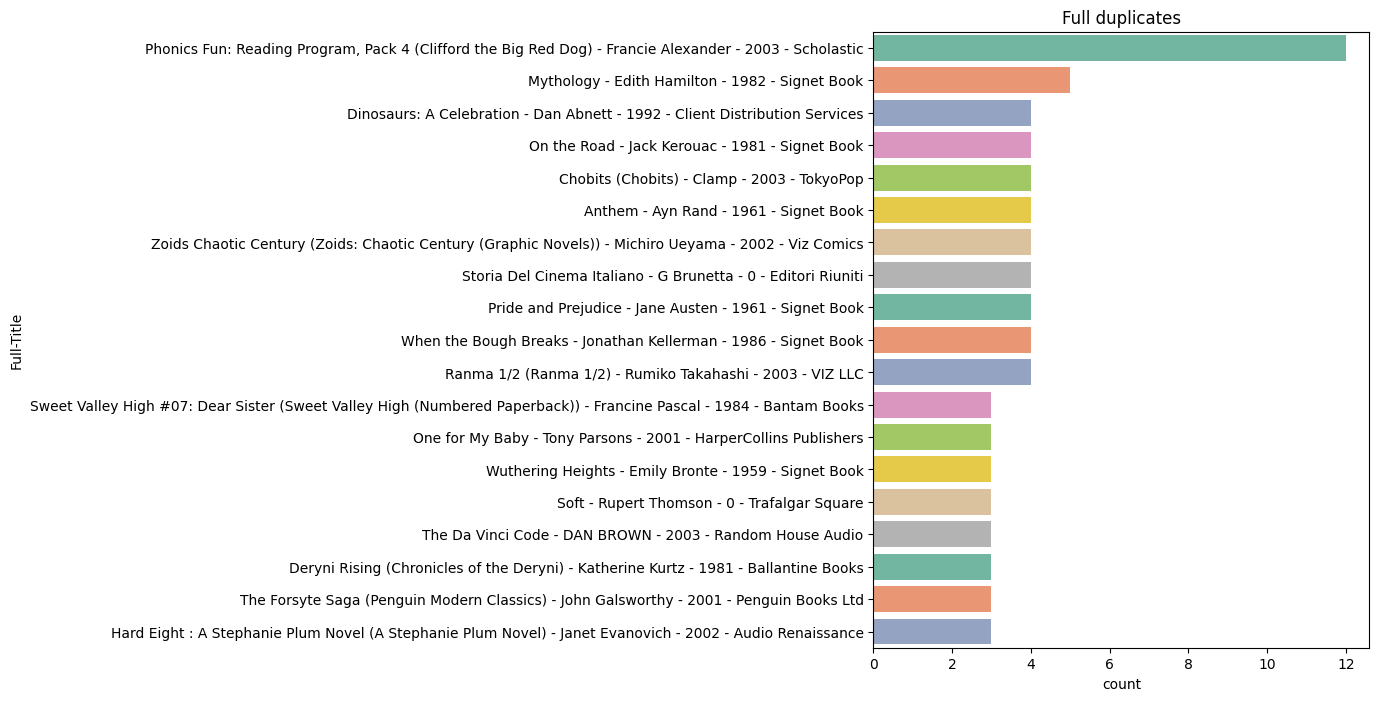

2025-08-25 17:55:44,366 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-25 17:55:44,370 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


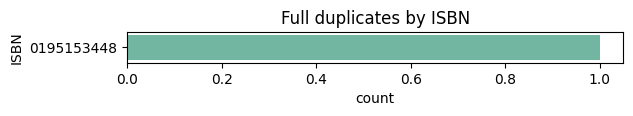

In [20]:
tdf = data_books.copy()
tdf["Full-Title"] = tdf["Book-Title"] + " - " + tdf["Book-Author"] + " - " + tdf["Year-Of-Publication"].astype(str) + " - " + tdf["Publisher"]
BarChartInspection("Full-Title", title="Full duplicates", top_n=20, dropna=False, figsize_scale=0.8).inspect(tdf)

tdf["Full-Title"] = tdf["ISBN"] + " - " + tdf["Full-Title"]
BarChartInspection("ISBN", title="Full duplicates by ISBN", top_n=1, dropna=False, figsize_scale=0.8).inspect(tdf)


Стоит сделать несколько практических замечаний, связанных с дальнейшим анализом и другим датасетом data_ratings

1. В data_ratings данные представлены связями между ISBN, юзером и его оценкой, поэтому просто выкинуть дубликаты может быть плохой идеей. Стоит склеить их в одну запись, а в ISBN хранить список из всех ISBN-ов, ассоциированных с дубликатами
2. Для книг, которые не являются полными дубликатами есть смысл считать общую популярность, а не только популярность отдельной книги. Подробнее про популярность будет дальше
3. Есть смысл рассмотреть добавление отдельной фичи, которая связывала бы книги, которые не являются полными дубликатами, но имеют один title и одного автора

### Распределение по годам

- Года в данных реалистичны. 
- За NaN, по всей видимости, отвечает только нулевой год
- Большая часть книг это вторая половина 20го века
- Есть несколько очень старых книг, но они малоизвестны и вряд ли будут вносить значимый импакт в систему
- Есть книги, которые выходят в будущем, что можно считать ошибкой в данных. Текущий год будем считать 2023им, тогда последний раз обновлялся датасет

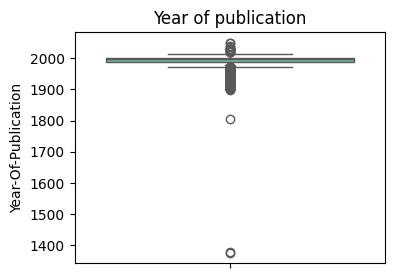

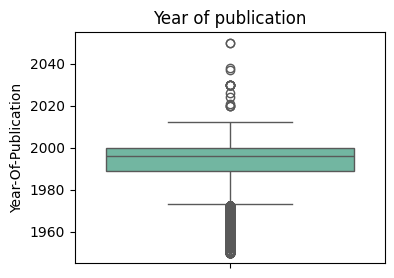

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
227531,9643112136,Dalan-i bihisht (Dastan-i Irani),Nazi Safavi,1378,Intisharat-i Quqnus,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...,http://images.amazon.com/images/P/9643112136.0...
253750,964442011X,Tasht-i khun,IsmaÂ°il Fasih,1376,Nashr-i Alburz,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...,http://images.amazon.com/images/P/964442011X.0...


In [21]:
# Отбросим все кривые данные, где

tdf = data_books[data_books["Year-Of-Publication"].astype(str).str.isnumeric()].copy()
tdf["Year-Of-Publication"] = tdf["Year-Of-Publication"].astype(int)
tdf = tdf[~(tdf["Year-Of-Publication"] == 0)]

BoxPlotInspection("Year-Of-Publication", title="Year of publication", figsize=(4,3)).inspect(tdf)



BoxPlotInspection("Year-Of-Publication", title="Year of publication", figsize=(4,3)).inspect(
    tdf[~(tdf["Year-Of-Publication"] < 1950)]
)

tdf[tdf["Year-Of-Publication"] <1500].head()

### Проведем простой препроцессинг

Проведём опять первоначальный processing

- Уберём Image-URL, так как это информация, с которым нам вообще ничего не даёт
- Типизируем каждый столбец и почистим кривые Year-Of-Publication
- Сольём дубликаты

In [22]:
from brs.preprocessing import BooksPreprocessingStrategy

data_books = BooksPreprocessingStrategy().preprocess(data_books)

In [23]:
data_books[data_books["Same-Book"].apply(lambda x: len(x)) > 1].head()

,Book-Title,Book-Author,Publisher,Year-Of-Publication,ISBN,Same-Book
41,!%@ (A Nutshell handbook),Donnalyn Frey,O'Reilly,1993,[1565920317],"[1565920317, 1565920465]"
42,!%@ (A Nutshell handbook),Donnalyn Frey,O'Reilly,1994,[1565920465],"[1565920317, 1565920465]"
59,'A Hell of a Place to Lose a Cow': An American...,Tim Brookes,National Geographic,2000,[0792276833],"[0792276833, 0792277295]"
60,'A Hell of a Place to Lose a Cow': An American...,Tim Brookes,National Geographic,2001,[0792277295],"[0792276833, 0792277295]"
78,'Salem's Lot,Stephen King,Doubleday Books,1993,[0385007515],"[0385007515, 0451168089, 067103975X]"


### Добавим новых фичей в датасет


Добавим три новых фичи (для первых двух добавим log1p значение)

1. Старость книги. Работать с годом выпуска книги можем быть неудобно. Лучше возьмем возраст книги

Напомню, что data_ratings представляет из себя матрицу, сопоставляющую пользователя и книгу, значениями в которой являются оценки. На основе неё можно получить сразу две фичи

2. Популярность. Как много у книги оценок. Популярность будем считать два раза. Один раз для книги в целом, второй раз для конкретного издания

3. Рейтинг. Средний рейтинг книги. Так же считаем два раза. Для книги и для издания

In [24]:
from brs.feature_engineering import PopularityFeature, RatingFeature, ElderityFeature

data_books = PopularityFeature(ratings_df=data_ratings).apply_transformation(data_books)
data_books = RatingFeature(ratings_df=data_ratings).apply_transformation(data_books)
data_books = ElderityFeature(ratings_df=data_ratings).apply_transformation(data_books)

In [25]:
from brs.analysis import HistogramInspection

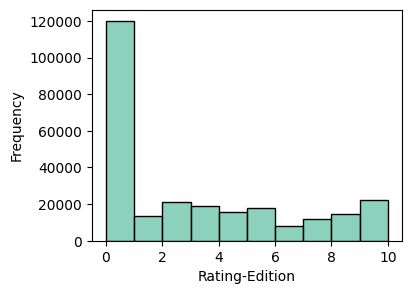

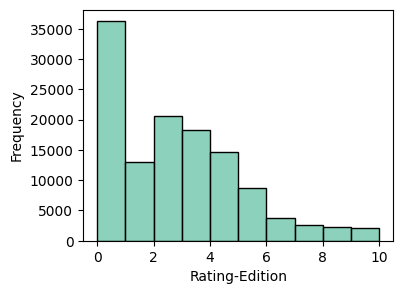

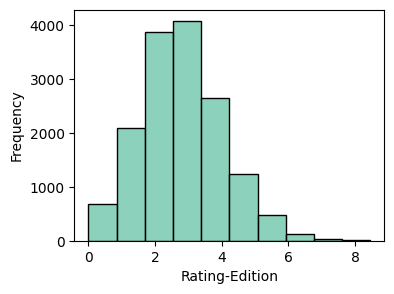

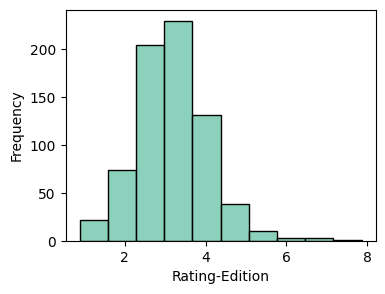

In [26]:
HistogramInspection(column_name="Rating-Edition", figsize=(4,3)).inspect(data_books)

tdf = data_books[data_books["Popularity-Edition"] > 1]
HistogramInspection(column_name="Rating-Edition", figsize=(4,3)).inspect(tdf)

tdf = data_books[data_books["Popularity-Edition"] > 10]
HistogramInspection(column_name="Rating-Edition", figsize=(4,3)).inspect(tdf)

tdf = data_books[data_books["Popularity-Edition"] > 100]
HistogramInspection(column_name="Rating-Edition", figsize=(4,3)).inspect(tdf)


Здесь заметим, что на книгах, у которых мало отзывов, подозрительно низкий рейтинг. Не очень понятно, чем это вызвано, возможно, это правда просто плохие книги.

Корреляции у этих величин нет

In [27]:
data_books[["Popularity-Edition","Rating-Edition"]].corr()

,Popularity-Edition,Rating-Edition
Popularity-Edition,1.000000,-0.003562
Rating-Edition,-0.003562,1.000000


## Датасет с оценками data_ratings

In [28]:
data_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [29]:
data_ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


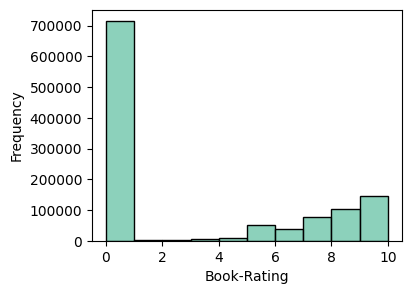

In [30]:
from brs.analysis import HistogramInspection

HistogramInspection(column_name="Book-Rating", figsize=(4,3)).inspect(data_ratings)

Как и предполагалось раньше, в датасете просто неадекватно большое количество нулей. Не очень ясно, что с ними сделать.


Возможные решения:
1. Выкосить все нули, но мы потеряем потенциально важную информацию
2. Определить подозрительных пользователей: тех, кто ставит только нули. Таких пользователей тоже можно разделить на две категории: тех, кто имеет совсем мало отзывов, и тех, кто стабильно заходит и ставит нули. Обе эти категории граждан довольно сомнительны и вероятно стоит убрать их из датасета,но может быть стоит убрать только кого-то одного.

Number of people of zero 'Mean-Rating' 27478 (9.853760695407699%)


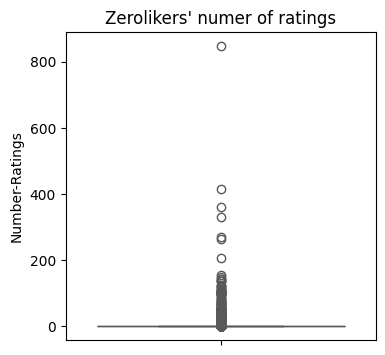

Number of people of zero 'Mean-Rating' and multiple ratings 771 (0.27648480588686714%)


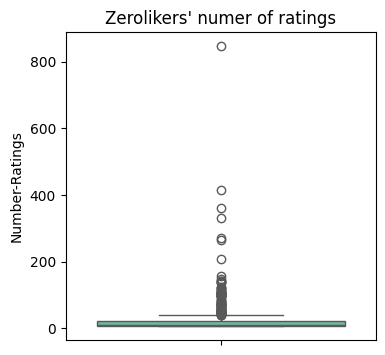

In [31]:
zero_likers = data_users[data_users["Mean-Rating"] == 0].copy()

print(f"Number of people of zero 'Mean-Rating' {zero_likers.shape[0]} ({zero_likers.shape[0] / data_users.shape[0] * 100}%)")

zero_likers.head()

BoxPlotInspection("Number-Ratings", title="Zerolikers' numer of ratings", figsize=(4,4)).inspect(zero_likers)


threshold = 5
suspicious_zero_likers = zero_likers[zero_likers["Number-Ratings"] > threshold]
print(f"Number of people of zero 'Mean-Rating' and multiple ratings {suspicious_zero_likers.shape[0]} ({suspicious_zero_likers.shape[0] / data_users.shape[0] * 100}%)")
BoxPlotInspection("Number-Ratings", title="Zerolikers' numer of ratings", figsize=(4,4)).inspect(
    suspicious_zero_likers
)


Вернемся к рассмотрению еще одной беды — пользователям со странным числом отзывов

Множество пользователей вообще не имеют отзывов. Как их использовать, абсолютно непонятно, поэтому проще их выкинуть, так как они не привносят вообще никакой информации

In [32]:
zrs = data_users[data_users["Number-Ratings"] == 0].shape[0]
ts = data_users.shape[0]
print(f"Users with zero reviews: {zrs} ({zrs/ts * 100}%)")

data_users = data_users[data_users["Number-Ratings"] > 0]

Users with zero reviews: 173575 (62.244941870055726%)


Абсолютное большинство пользователей написали меньше 40 отзывов. Избавимся от странных ребят, которые оставили больше.

Users with less than 10 review 92186 (87.56019490326074%)


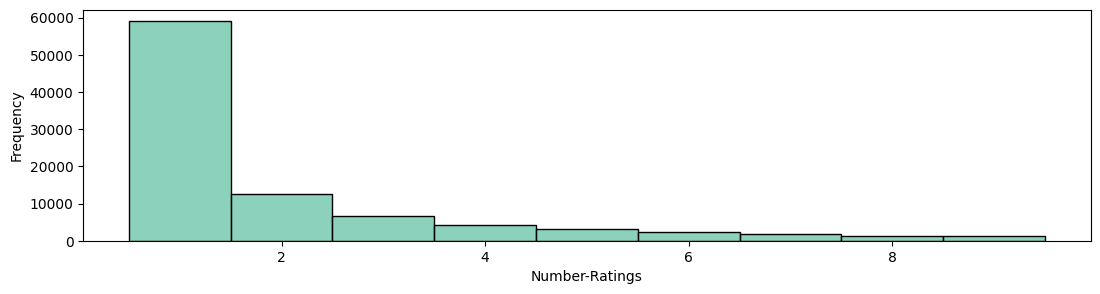

Users with less than 40 review 101132 (96.05729320023175%)


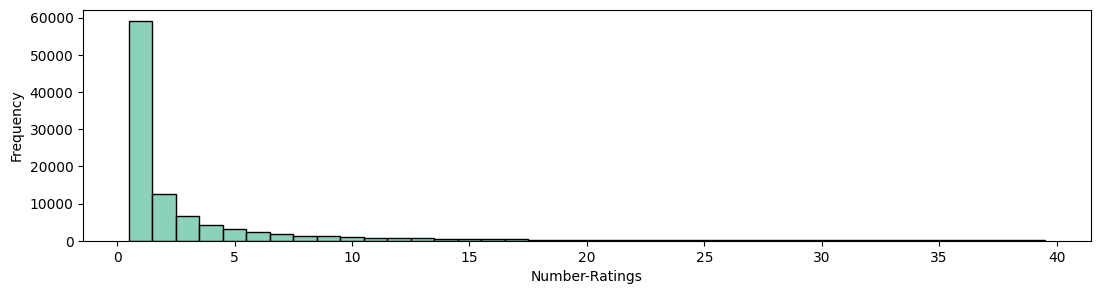

Users with less than 100 review 103458 (98.26657675028258%)


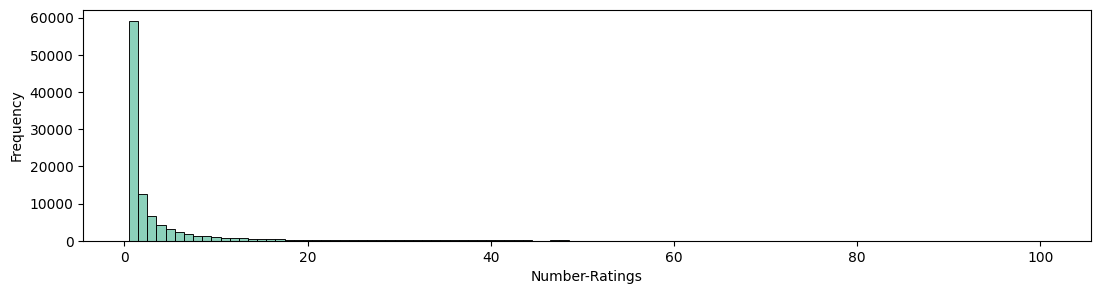

In [33]:
tdf = data_users[data_users["Number-Ratings"] < 10]

print(f"Users with less than 10 review {tdf.shape[0]} ({tdf.shape[0] / data_users.shape[0] * 100}%)")

HistogramInspection(column_name="Number-Ratings", discrete=True, figsize=(13,3)).inspect(tdf)

tdf = data_users[data_users["Number-Ratings"] < 40]
print(f"Users with less than 40 review {tdf.shape[0]} ({tdf.shape[0] / data_users.shape[0] * 100}%)")
HistogramInspection(column_name="Number-Ratings", discrete=True, figsize=(13,3)).inspect(tdf)

tdf = data_users[data_users["Number-Ratings"] <= 100]
print(f"Users with less than 100 review {tdf.shape[0]} ({tdf.shape[0] / data_users.shape[0] * 100}%)")
HistogramInspection(column_name="Number-Ratings", discrete=True, figsize=(13,3)).inspect(tdf)

Больше всего информации для обучения и валидирования системы мы скорее всего сможем извлечь из цепочек по 5-10+ книг. Так как всё таки информация от 1-2 отзывов нам тоже будет маловато, хотя эти данные более-менее показывают связь книги и демографической категории.

Таких самых лучших данных у нас сравнительно немного. Всего 15.500, но информациях из них может быть достаточно полезной, чтоб на основе нее лучше всего строилась система

Users with less than 40 review 15566 (14.784913043891226%)


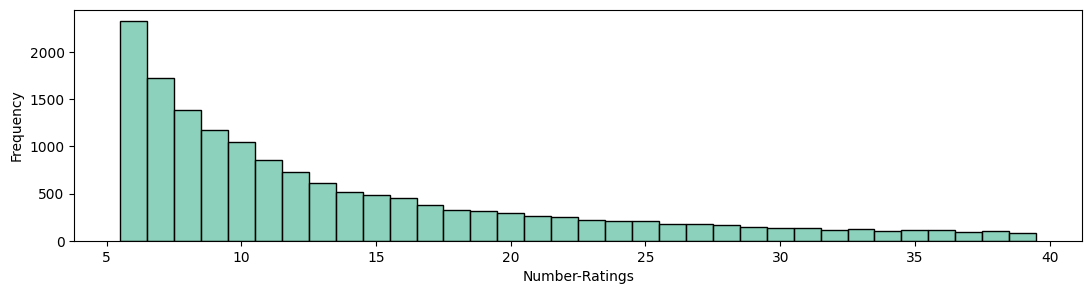

In [34]:
tdf = data_users[(data_users["Number-Ratings"] < 40) & (data_users["Number-Ratings"] > 5)]
print(f"Users with less than 40 review {tdf.shape[0]} ({tdf.shape[0] / data_users.shape[0] * 100}%)")
HistogramInspection(column_name="Number-Ratings", discrete=True, figsize=(13,3)).inspect(tdf)

Проверим также на всякий случай. Нет ли в рейтингах каких-то User-ID, которых нет в data_users. Может быть там User-ID битые и мы сможем их поправить и выудить еще информации

Таких нет

In [35]:
total_ratings_count = data_ratings.shape[0]
total_users_ratings_count = data_users["Number-Ratings"].sum()

print(f"Количество неучтенных оценок: {total_ratings_count - total_users_ratings_count}")

Количество неучтенных оценок: 0


### Выводы

1. Данных много, но очень много вопрос к качеству рейтингов. В остальном всё более-менее неплохо
2. Для подготовки чистых данных имеет смысл вырезать ряд пользователей:
    - Тех, у кого много нулей в оценках и больше нет ничего
    - Тех, кто не оставлял оценки
    - Тех, кто оставил слишком много оценок
3. Чистки в рядах пользователей стоит провести до подсчета фич data_books, основанных на этих оценках

## Общие выводы по всем датасетам

### Для пользователей

- ~70% пользователей из англоговорящих стран 
- ~35% пользователей от 18 до 30 лет, ~35% от 30 до 45 лет и ещё ~20% от 18 до 60 лет
- ~40% пользователей оставляли хоть какие-то оценки для книг, соответственно пригодны для использования
- Из них около 15% (15-16 тысяч) записей представляют наибольший интерес, так как содержат цепочки от 5 и более отзывов


### Для книг
- В датасете присутсвуют дубликаты, но их количество не критично. Большая часть представлена разными изданиями одной и той же книги, что является важной информацией и в полном смысле дубликатом считаться не может
- Почти для всех книг в датасете все, представленные параметры: год публикации, автор, издательство, название проставлены и имеют вполне разумные значения. Большая часть представленных книг была опубликована в середине 20го века
- Книги, на которых количество отзывов очень низко (1-2) склонны иметь единственной оценкой 0, что потенциально может плохо сказаться на рекомендации новых книг, которые еще не были представлены пользователям ранее


### Шаги для подготовки clear версии датасетов
1. Почистить рейтинги и пользователей. Избавится от найденных выбросов и подозрительных значений
2. Использовать препроцессинги и экстракторы фичей описанные ранее

In [36]:
from brs.ingestion import LoadLocalDataset

lld = LoadLocalDataset()

data_books = lld.load_dataset("books")
data_users = lld.load_dataset("users")
data_ratings = lld.load_dataset("ratings")

from brs.preprocessing import UsersPreprocessingStrategy, BooksPreprocessingStrategy
from brs.feature_engineering import AgeGroupsFeature, CountryFeature, MeanRatingFeature, NumRatingsFeature
from brs.feature_engineering import PopularityFeature, RatingFeature, ElderityFeature

data_users = UsersPreprocessingStrategy().preprocess(data_users)
data_users = AgeGroupsFeature().apply_transformation(data_users)
data_users = CountryFeature().apply_transformation(data_users)
data_users = MeanRatingFeature(ratings_df=data_ratings).apply_transformation(data_users)
data_users = NumRatingsFeature(ratings_df=data_ratings).apply_transformation(data_users)


# Держим в уме, что threshold это гиперпараметр
# Здесь threshold отвечает за максимальное число нулевых оценок, если все оценки нулевые
zero_likers_threshold = 3
mask = (data_users["Mean-Rating"] == 0) & (data_users["Number-Ratings"] > zero_likers_threshold)
data_users = data_users[~mask]

# Держим в уме, что threshold это гиперпараметр
# Здесь threshold отвечает за максимальное число оценок у одного пользователя. Пользователи, оставившие больше считаются подозрительными
max_rates_threshold = 100
mask = (data_users["Number-Ratings"] == 0) | (data_users["Number-Ratings"] > max_rates_threshold)
data_users = data_users[~mask]


# В data_ratings необходимо удалить все оценки от нерелевантных пользователей
data_ratings = data_ratings[data_ratings["User-ID"].isin(data_users["User-ID"])]

data_books = BooksPreprocessingStrategy().preprocess(data_books)
data_books = PopularityFeature(ratings_df=data_ratings).apply_transformation(data_books)
data_books = RatingFeature(ratings_df=data_ratings).apply_transformation(data_books)
data_books = ElderityFeature(ratings_df=data_ratings).apply_transformation(data_books)

d:\z\Conspects\_Summer\BRS\brs\ingestion\load_local.py:42: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(dataset_path)


На графиках дальше видно, что отсечение пользователей, которые ставят много нулей приносит пользу и делает распределние оценок более реалистичный, мене скошенным в сторону нуля, как было ранее. Можно поигратся с zero_likers_threshold, но где-то в районе трёх мы получаем оптимальные значения.

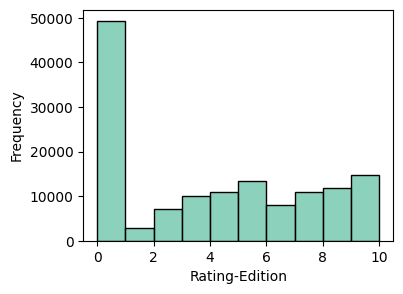

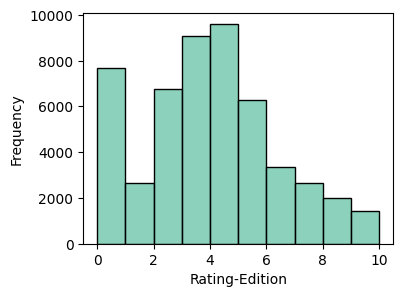

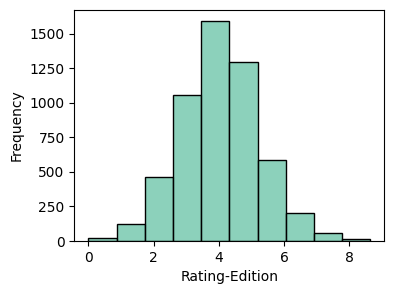

In [37]:
HistogramInspection(column_name="Rating-Edition", figsize=(4,3)).inspect(data_books)

tdf = data_books[data_books["Popularity-Edition"] > 1]
HistogramInspection(column_name="Rating-Edition", figsize=(4,3)).inspect(tdf)

tdf = data_books[data_books["Popularity-Edition"] > 10]
HistogramInspection(column_name="Rating-Edition", figsize=(4,3)).inspect(tdf)

## Итоговые препроцессинг

In [38]:
from brs.ingestion import LoadLocalDataset

lld = LoadLocalDataset()

data_books = lld.load_dataset("books")
data_users = lld.load_dataset("users")
data_ratings = lld.load_dataset("ratings")

from brs.preprocessing import UsersClarifyStrategy, BooksClarifyStrategy
data_users = UsersClarifyStrategy(ratings_df=data_ratings, zero_likers_threshold=3).preprocess(data_users)
data_books = BooksClarifyStrategy(ratings_df=data_ratings, clear_users_df=data_users).preprocess(data_books)

d:\z\Conspects\_Summer\BRS\brs\ingestion\load_local.py:42: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(dataset_path)


In [39]:
import brs.config as config

os.makedirs(f"{config.root_dir}/data/clear/kaggle-books", exist_ok=True)

data_users.to_csv(f"{config.root_dir}/data/clear/kaggle-books/users_preprocessed.csv", index=False)
data_books.to_csv(f"{config.root_dir}/data/clear/kaggle-books/books_preprocessed.csv", index=False)
data_ratings.to_csv(f"{config.root_dir}/data/clear/kaggle-books/ratings_preprocessed.csv", index=False)